In [1]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from sklearn.datasets import make_blobs


In [2]:
# Create sample data
X, _ = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42)


In [10]:
# Function to initialize centroids randomly
def initialize_centroids(X, k):
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

# Function to assign points to clusters
def assign_clusters(X, centroids, cov_matrices):
    clusters = {i: [] for i in range(len(centroids))}
    for x in X:
        distances = []
        for idx, centroid in enumerate(centroids):
            cov_mat = cov_matrices[idx]
            if np.any(np.isnan(cov_mat)) or np.any(np.isinf(cov_mat)):
                return None  # Trigger reinitialization
            try:
                inv_covmat = inv(cov_mat)
            except np.linalg.LinAlgError:
                return None  # Trigger reinitialization
            dist = mahalanobis(x, centroid, inv_covmat)
            distances.append(dist)
        cluster_idx = np.argmin(distances)
        clusters[cluster_idx].append(x)
    return clusters

def update_centroids(clusters):
    """Updates centroids as the mean of all points assigned to each cluster."""
    centroids = []
    for key in sorted(clusters.keys()):
        centroids.append(np.mean(clusters[key], axis=0))
    return centroids

def update_cov_matrices(clusters):
    """Updates covariance matrices for each cluster."""
    cov_matrices = []
    for key in sorted(clusters.keys()):
        cov_matrices.append(np.cov(np.array(clusters[key]).T))
    return cov_matrices


In [15]:
def mahalanobis_kmeans(X, k, max_iter=100):
    while True:
        centroids = initialize_centroids(X, k)
        print("initialize centroid: ", centroids)
        cov_matrices = [np.eye(X.shape[1])] * k 
        for _ in range(max_iter):
            clusters = assign_clusters(X, centroids, cov_matrices)
            for key in sorted(clusters.keys()):  
                print(key, clusters[key])
            if clusters is None:
                break  # Reinitialize if inversion fails
            new_centroids = update_centroids(clusters)
            new_cov_matrices = update_cov_matrices(clusters)
            for i in range(k):
                print(i, new_centroids[i])
                print(i, new_cov_matrices[i])
            print("----")
            if np.allclose(centroids, new_centroids):
                return clusters, centroids, cov_matrices  # Converged
            
            centroids, cov_matrices = new_centroids, new_cov_matrices

In [16]:
# Define a threshold for outlier detection
k=3
clusters, centroids, cov_matrices = mahalanobis_kmeans(X, k)

threshold = 3  # This can be adjusted based on the dataset

outliers = []
for idx, centroid in enumerate(centroids):
    inv_covmat = inv(cov_matrices[idx])
    for x in clusters[idx]:
        dist = mahalanobis(x, centroid, inv_covmat)
        if dist > threshold:
            outliers.append(x)
    # Remove outliers from the cluster
    clusters[idx] = [x for x in clusters[idx] if mahalanobis(x, centroid, inv_covmat) <= threshold]


initialize centroid:  [[-7.12859134 -5.90853864]
 [-1.88353028  8.15712857]
 [-2.72886951  9.3713987 ]]
0 [array([-7.33898809, -7.72995396]), array([-7.74004056, -7.26466514]), array([-8.91775173, -7.8881959 ]), array([-7.53026976, -7.36723498]), array([-8.50716963, -6.83202465]), array([-6.99195524, -7.10107919]), array([-6.34982301, -5.43854097]), array([-7.45639852, -6.12471837]), array([-6.04929137, -7.73619342]), array([-8.39481825, -5.51323533]), array([-6.12263857, -7.80227492]), array([-6.98665755, -7.91535192]), array([-7.36723342, -7.31266778]), array([-6.80806095, -7.35776704]), array([-6.54202453, -7.29198656]), array([-6.88759983, -5.40016545]), array([-6.51302895, -7.81998938]), array([-5.70033001, -6.81259111]), array([-6.48517505, -7.30109407]), array([-6.64401263, -6.1092444 ]), array([-3.80074638, -5.76053468]), array([-7.12859134, -5.90853864]), array([-6.16801231, -8.00475169]), array([-8.58300963, -6.93565729]), array([-5.8212027 , -8.63884908]), array([-7.5793527 

In [17]:
# Convert clusters to arrays for easier handling
clusters = {key: np.array(value) for key, value in clusters.items()}
outliers = np.array(outliers)


In [18]:
print(outliers)

[[-3.80074638 -5.76053468]
 [ 5.15492652  5.82590117]
 [ 1.3986115   0.94878204]
 [-5.12894273  9.83618863]]


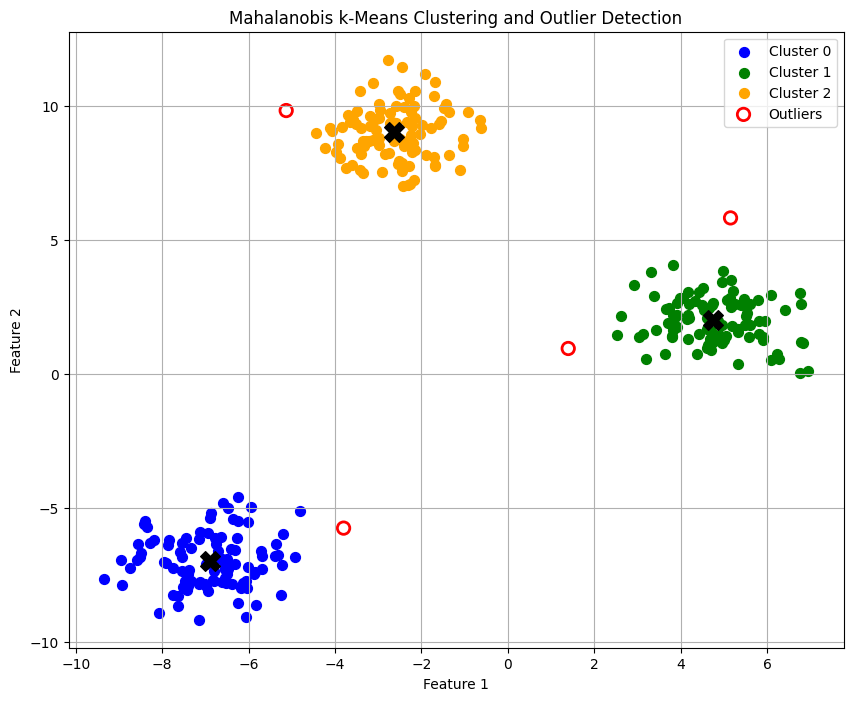

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these variables are defined from the clustering algorithm:
# clusters: a dictionary {cluster_index: np.array([[x1, y1], [x2, y2], ...])}
# centroids: a list of centroid coordinates, e.g., [np.array([x, y]), ...]
# outliers: a numpy array of outlier points, shape (n_outliers, n_features)

# Define a color palette for clusters
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']

plt.figure(figsize=(10, 8))

# Plot each cluster with a unique color
for idx, points in clusters.items():
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], 
                s=50, 
                color=colors[idx % len(colors)], 
                label=f'Cluster {idx}')
    # Plot cluster centroids as black X markers
    plt.scatter(centroids[idx][0], centroids[idx][1], 
                marker='X', 
                s=200, 
                color='black')

# Plot outliers with red circle markers (no fill)
if outliers.size > 0:
    plt.scatter(outliers[:, 0], outliers[:, 1], 
                s=80, 
                facecolors='none', 
                edgecolors='red', 
                linewidths=2, 
                label='Outliers')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Mahalanobis k-Means Clustering and Outlier Detection")
plt.legend()
plt.grid(True)
plt.show()
